<a href="https://colab.research.google.com/github/chensteven/ml_notes/blob/code/DAT120_ML_Regression_Linear_Regression_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://conted.ucalgary.ca/images/ucalgary-conted.svg" width='30%'> 

<h1 align="left"> DAT120: Linear Regression (Demo) </h1>
Delivered in collaboration with WeCloudData
<br>

----------

In [ ]:
import math
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model, datasets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline


## Linear Regression Intuition


### Create Sample Data  

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000,
                  centers=[[0.1, 0.1],[0.9, 0.9]],
                  cluster_std=0.05,
                  n_features=2,
                  random_state=0)

print ('Vectors: \n', X[:10])
print ('Labels: \n', y[:10])

Vectors: 
 [[ 0.04757235  0.0289991 ]
 [ 0.18820262  0.12000786]
 [ 0.87521023  0.96082889]
 [ 0.20583955  0.01945608]
 [ 0.86345632  0.81791484]
 [ 0.94607042  0.92304072]
 [ 0.21296545  0.09788714]
 [-0.0119802   0.12007495]
 [ 0.75026936  0.94404688]
 [ 0.8935879   0.88641142]]
Labels: 
 [0 0 1 0 1 1 0 0 1 1]


### Plotting utility functions 

> Note that these functions are created to help students understand how to plot regression data and decision boundary. 


#### <font color='#FC7307'> $\delta$ Plot Data

In [ ]:
def plot_data(X, y, title=None):
    plt.figure(figsize=(6,4))
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.PRGn, alpha=0.3)
    #plt.plot([-0.5, 1.5], [1.5, -0.5], alpha=0.6, lw=3)
    plt.xlabel('X1', fontsize=12)
    plt.ylabel('X2', fontsize=12)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title('{}'.format(title), fontsize=14)
    plt.show()

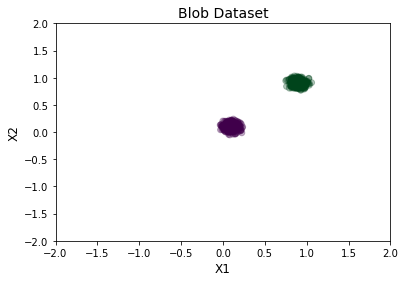

In [ ]:
plot_data(X, y, title='Blob Dataset')

#### <font color='#FC7307'> $\delta$ Plot regression data


In [ ]:
def bp_plot_reg(x, y, y_pred=[], line=False):
    import bokeh.plotting as bp
    import matplotlib.pyplot as plot
    %matplotlib inline
    bp.output_notebook()

    WIDTH = 400
    HEIGHT = 300
    FONTSIZE = '14pt'

    fig = bp.figure(plot_width=WIDTH, plot_height=HEIGHT, 
                    title='Bokeh Regression', active_scroll = "auto")

    fig.title.text_font_size = FONTSIZE

    s1 = fig.circle(x, y, size=10, color='navy', alpha=0.5)
    
    if line:
        s_pred_line = fig.line(x, y_pred, color='orange', line_width=3)
        
    fig.xaxis.axis_label = "X"
    fig.yaxis.axis_label = "Y"

    bp.show(fig)

#### <font color='#FC7307'> $\delta$ Plot decision boundary

The `plot_decision_boundary` function takes a trained ML model, feature dataset (X), and target dataset (y) as parameters. It uses the trained model to create predictions for all data points generated from a meshgrid, then uses the contour plot to visualize the decision boundary. 

> This `plot_decision_boundary` function will be called many times in this tutorial, so let's create a function

In [ ]:
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(6,4))
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha=0.5)
    ax.scatter(X[:,0], X[:,1], c=y, alpha=0.7)

## Algorithm: Linear Models

### Understand Linear Models (Regression)


In [ ]:
# loading necessary libraries and setting up plotting libraries
import numpy as np
import seaborn as sns

import bokeh.plotting as bp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.datasets import make_regression 
from scipy import stats 
from bokeh.models import  WheelZoomTool, ResetTool, PanTool
from bokeh.layouts import gridplot
#from JSAnimation import IPython_display

%matplotlib inline

#### <font color='#FC7307'> $\delta$ Generate random regression data

In [ ]:
from sklearn.datasets import make_regression
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=10,
                       random_state=2015)

x = np.c_[np.ones(x.shape[0]), x] 

In [ ]:
bp_plot_reg(x.flatten(), y)

Loading BokehJS ...

#### <font color='#FC7307'> $\delta$ CYOM: Define the gradient descent function
    
CYOM: **C**reate **Y**our **O**wn **M**odel

> - Note that we don't expect students to be able to write their own optimization functions. In practice, most of the time data scientists will leverage existing functions and libraries to train models. So it's ok to skip this section. But we still encourage you to try understanding it. 
    
<img src='https://s3.amazonaws.com/weclouddata/images/python/ml_regression_gradient_descent.gif' width='60%'>

In [ ]:
# Don't worry about the function itself. Just want to show you how important numpy is for numeric computing in Python

def gradient_descent(x, y, iters, alpha):
    import numpy as np
    costs = []
    m = y.size # number of data points
    theta = np.random.rand(2) # random start
    history = [] # to store all thetas
    preds = []
    for i in range(iters):
        pred = np.dot(x, theta)
        error = pred - y 
        cost = np.sum(error ** 2) / (2 * m)
        costs.append(cost)
        
        if i % 25 == 0: 
            preds.append(pred)

        gradient = x.T.dot(error)/m 
        theta = theta - alpha * gradient  # update
        history.append(theta)
        
    return history, costs, preds

#### <font color='#FC7307'> $\delta$ CYOM: Define the linear regression function


In [ ]:
def linear_regression(x, y, alpha, iterations):
    alpha = alpha # set step-size
    iters = iterations # set number of iterations
    history, cost, preds = gradient_descent(x, y, iters, alpha)
    return history, cost, preds

#### <font color='#FC7307'> $\delta$ Plot cost function history

In [ ]:
def bp_plot_cost_hist(cost):
    import bokeh.plotting as bp
    import matplotlib.pyplot as plot
    %matplotlib inline
    bp.output_notebook()
    
    x_iteration, y_cost = (zip(*enumerate(cost)))

    fig = bp.figure(width=590, plot_height=350, 
                title='Loss over iterations',
                x_axis_label='Iteration',
                y_axis_label='Loss',
                active_scroll="auto")
    s1 = fig.line(x_iteration,y_cost, line_width=4, color='navy', alpha=0.5)
    fig.title.text_font_size = '16pt'
    fig.yaxis.axis_label_text_font_size = "14pt"
    fig.xaxis.axis_label_text_font_size = "14pt"

    bp.show(fig)

In [ ]:
history, costs, preds = linear_regression(x, y, alpha=0.01, iterations=500)

In [ ]:
bp_plot_cost_hist(costs)

Loading BokehJS ...

#### <font color='#FC7307'> $\delta$ Plot fitted regression line

In [ ]:
theta_1 = history[-1]
pred_1 = np.dot(x, theta_1)

bp_plot_reg(x[:,1], y, pred_1, line=True)

Loading BokehJS ...

---

# Regression Analysis with `Statsmodels` and `Sklearn` <a name="regression"></a></a><font size='3'>[Back to TOC](#toc)</font>

## Data/Feature Preparation 

### Load Boston Housing Dataset  

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per `$10,000` 
11. PTRATIO: pupil`-`teacher ratio by town 
12. B: 1000(Bk `-` 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: `%` lower status of the population 
14. MEDV: Median value of owner-occupied homes in $1000's

In [ ]:
import pandas as pd

boston_df = pd.read_csv("https://s3.amazonaws.com/weclouddata/datasets/random/Boston.csv")
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### $\Delta$ 4.1.2 - Data Exploration  <a name="reg-boston"></a><font size='3'>[Back to TOC](#toc)</font>


#### <font color='#FC7307'> $\delta$ Describe Statistics

In [ ]:
boston_df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


#### <font color='#FC7307'> $\delta$ Correlation

<AxesSubplot:>

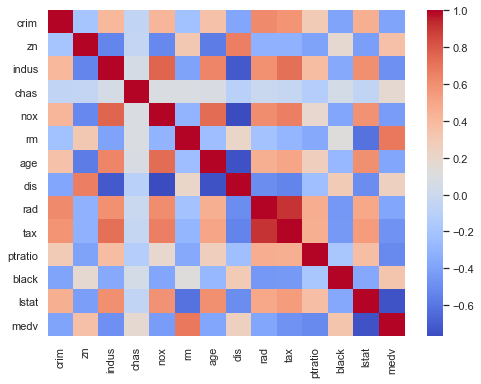

In [ ]:
from matplotlib import cm

sns.set(rc={'figure.figsize':(8,6)})

boston_corr = boston_df.corr()
sns.heatmap(boston_corr, cmap=cm.coolwarm)

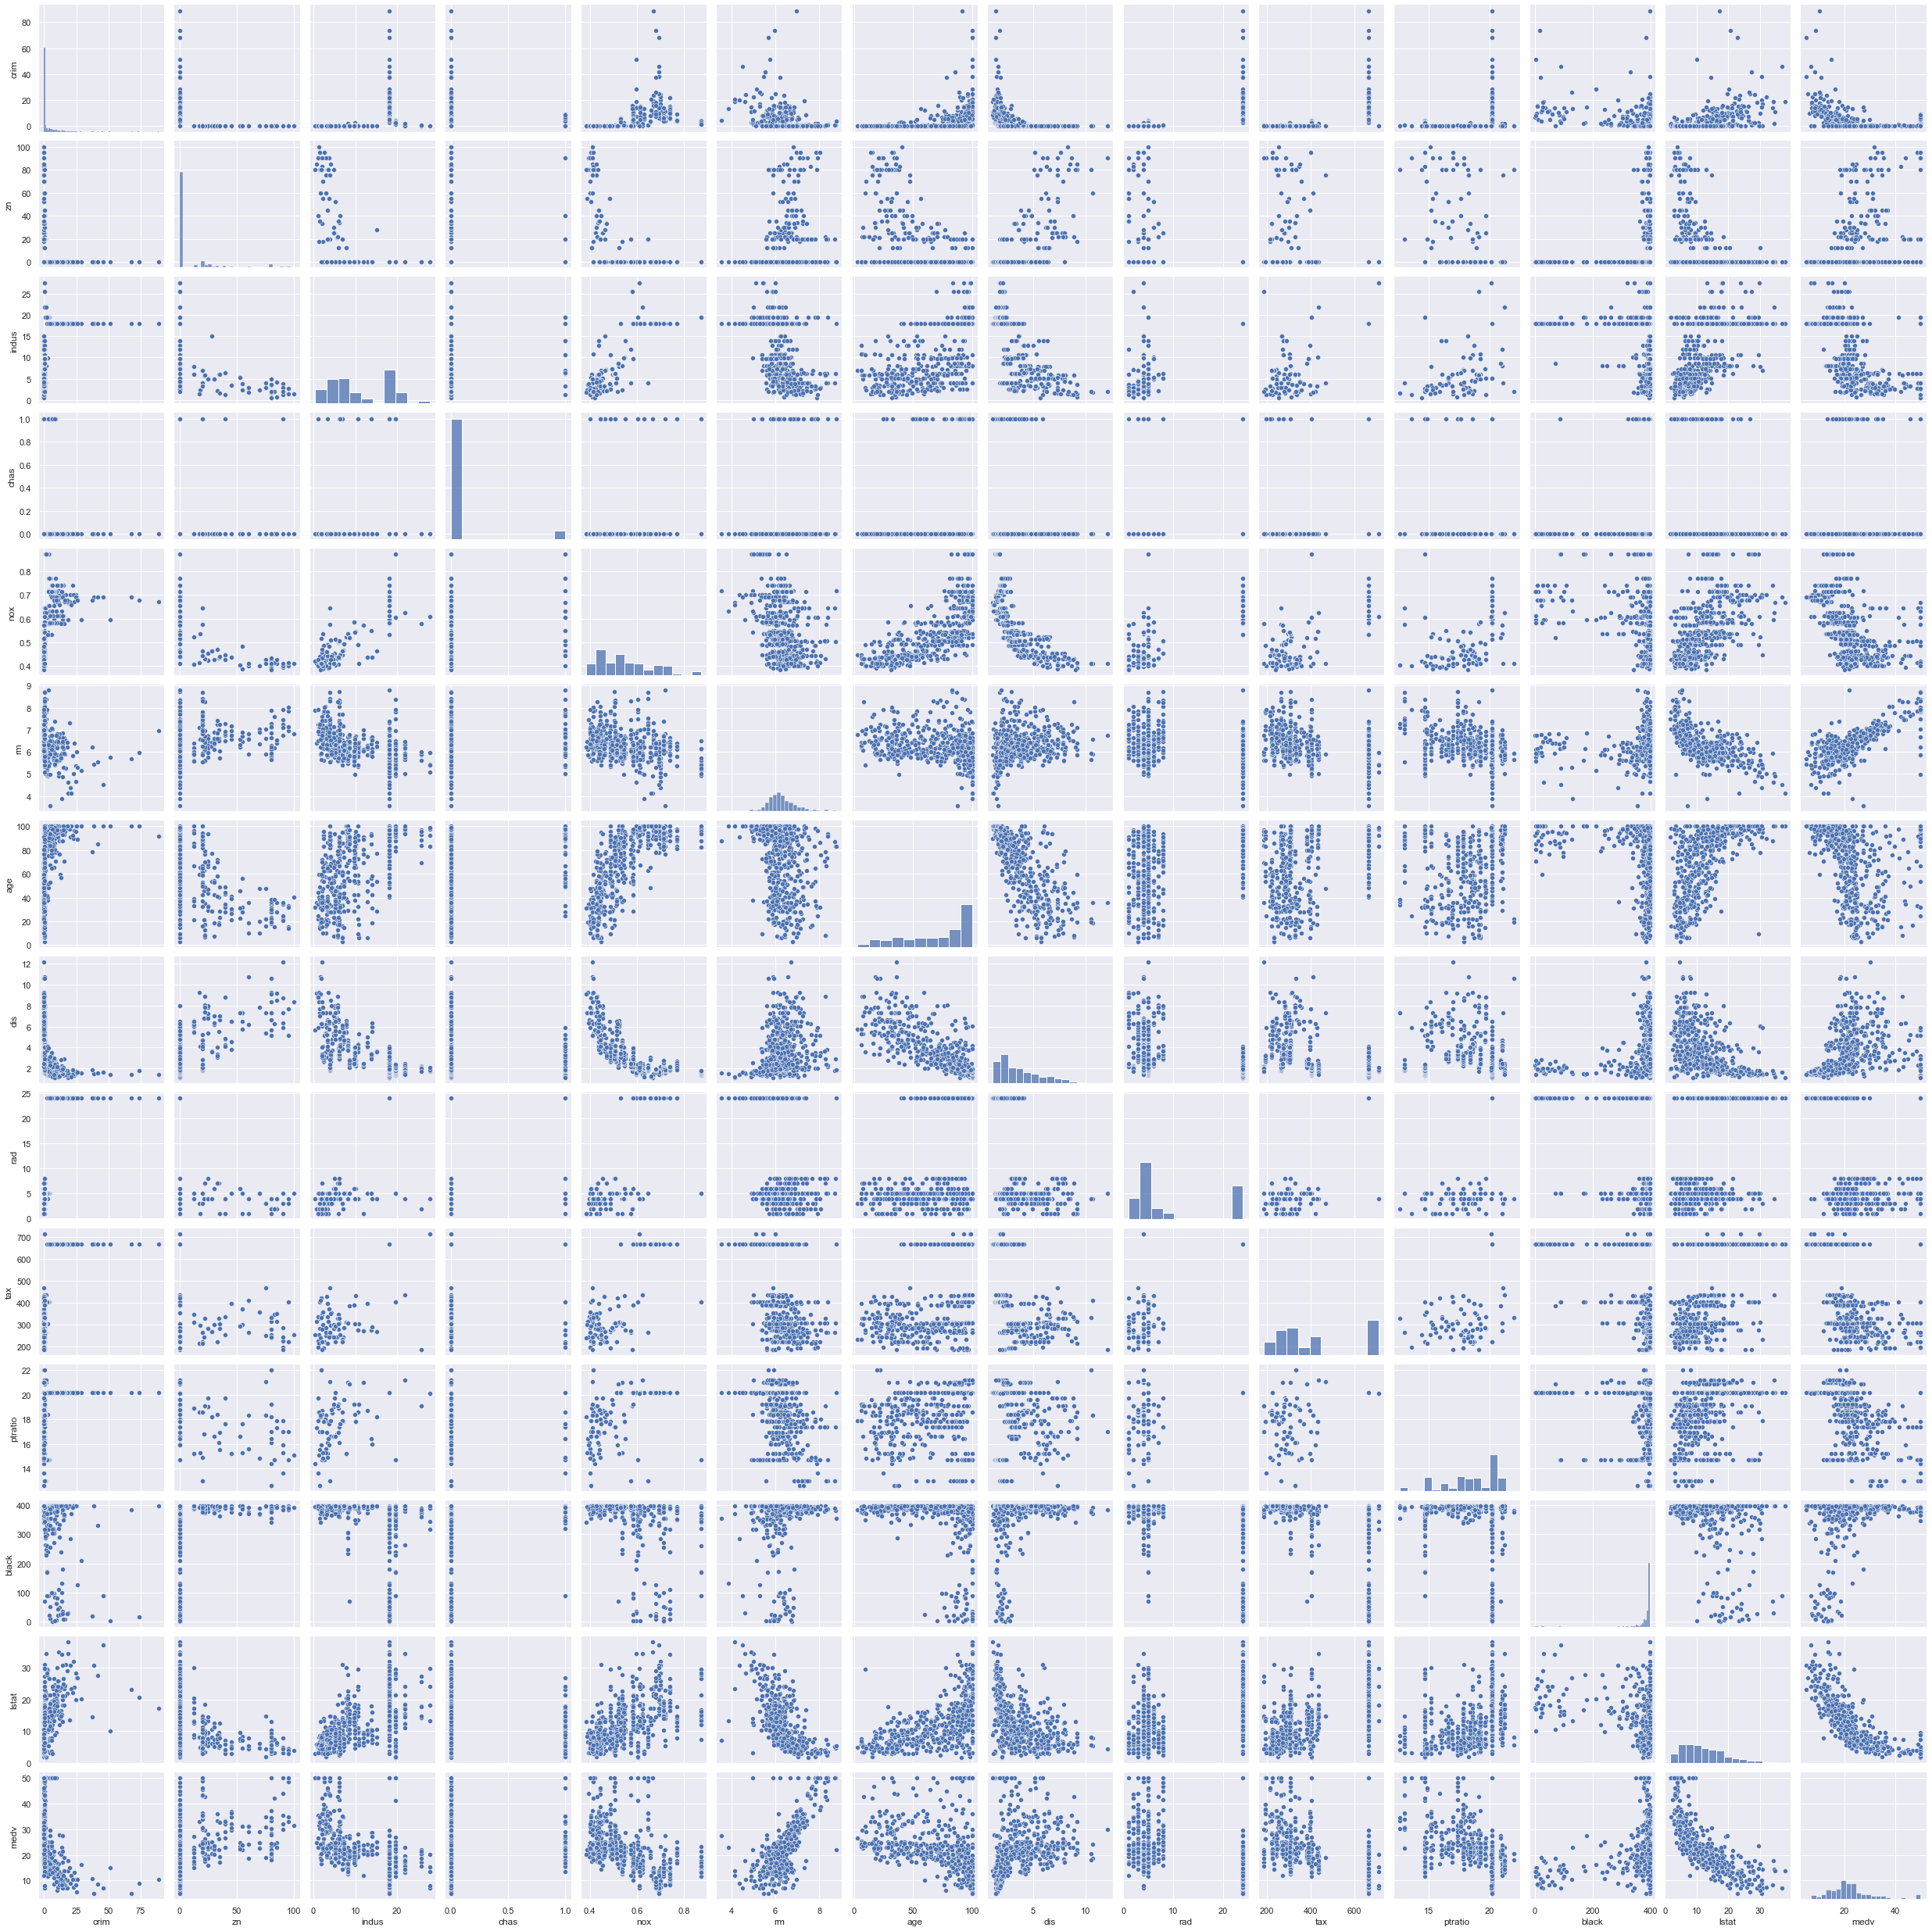

In [ ]:
import seaborn as sns

sns.pairplot(boston_df)

### Target/Feature Definition 


In [ ]:
X = boston_df[['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad','tax', 'ptratio', 'black', 'lstat']]
y = boston_df["medv"].values

### Train/Test Split 


In [ ]:
from sklearn.model_selection import train_test_split

# Use "train_test_split" function to split data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=4)

print("Train_X: {}".format(X_train.shape))
print("Test_X: {}".format(X_test.shape))
print("Train_y: {}".format(y_train.shape))
print("Test_y: {}".format(y_test.shape))

Train_X: (354, 13)
Test_X: (152, 13)
Train_y: (354,)
Test_y: (152,)


### Feature Scaling 


In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

## Linear Regression 

`sklearn.linear_model.LinearRegression` and `statsmodels.api.OLS` are two commons modules used for fitting regression models. In this section, we will introduce `statsmodels` which provide more statistical testing metrics compared to `sklearn` that focuses on prediction. 


> Note that `sklearn` package doesn't really provide p-value and some other statistics. It's mainly because sklearn takes an ML approach and a model that validates well is more important than having more significant parameter statistics. In short, the ML community believes strongly in prediction performance over interpretation. There're more modern approaches to interpretation of model performance and significant features. 

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

### Fit Linear Regression using `statsmodels` 

> Use `statsmodels` package if you want a more statistical approach to your regression problems. It's not that common in the ML community though. 


#### <font color='#FC7307'> $\delta$ Model Fitting

In [ ]:
X_train_ss = sm.add_constant(X_train_ss)  # add the intercept term
X_test_ss = sm.add_constant(X_test_ss)  # add the intercept term

In [ ]:
ols = sm.OLS(y_train, X_train_ss).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     77.06
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           6.42e-93
Time:                        23:01:44   Log-Likelihood:                -1024.2
No. Observations:                 354   AIC:                             2076.
Df Residuals:                     340   BIC:                             2130.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1223      0.237     93.401      0.000      21.656      22.588
x1            -1.0867      0.317     -3.428      0.001      -1.710      -0.463
x2             1.2861      0.363      3.547      0.000       0.573       1.999
x3            -0.0607      0.479     -0.127      0.899      -1.002       0.881
x4             1.0311      0.245      4.217      0.000       0.550       1.512
x5            -1.6888      0.493     -3.428      0.001      -2.658      -0.720
x6             2.1673      0.327      6.625      0.000       1.524       2.811
x7            -0.0953      0.425     -0.224      0.823      -0.931       0.740
x8            -3.3263      0.486     -6.838      0.000      -4.283      -2.370
x9             2.8897      0.658      4.395      0.000       1.596       4.183
x10           -2.3927      0.723     -3.308      0.001      -3.815      -0.970
x11           -1.7456      0.312     -5.597      0.000      -2.359      -1.132
x12            0.8542      0.272      3.139      0.002       0.319       1.390
x13           -3.7084      0.411     -9.032      0.000      -4.516      -2.901
==============================================================================
Omnibus:                      132.494   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              542.712
Skew:                           1.593   Prob(JB):                    1.42e-118
Kurtosis:                       8.162   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ols.params

array([22.12231638, -1.08673085,  1.28610283, -0.0607036 ,  1.03108551,
       -1.6887816 ,  2.16731202, -0.09530735, -3.32627056,  2.88971894,
       -2.39272265, -1.74561418,  0.85424206, -3.70842299])

In [ ]:
ols.tvalues

array([93.40125516, -3.42762382,  3.54657656, -0.12684317,  4.21662291,
       -3.42795966,  6.62524844, -0.22445218, -6.83832899,  4.39498521,
       -3.30834365, -5.59716892,  3.13907449, -9.0316376 ])

#### <font color='#FC7307'> $\delta$ Make Prediction on Test

In [ ]:
y_test_pred = ols.predict(X_test_ss)

#### <font color='#FC7307'> $\delta$ Model Evaluation

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.7121818377409199

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_test_pred)

30.0539933071241

---
### Fit Linear Regression using `sklearn` 

> The sklearn package or pytorch/tensorflow are more popular libraries for regression/neural network problems. 


#### <font color='#FC7307'> $\delta$ Model Fitting

> We skipped many details because the goal of this notebook is for everyone to understand the regression problem. We will introduce the following in more detail in the later lectures:
>   - Feature engineering and selection
>   - Cross validation
>   - Hyperparameter tuning
>   - Model interpretation


In [ ]:
reg = LinearRegression()
reg.fit(X_train_ss, y_train)
reg.coef_

array([ 0.        , -1.08673085,  1.28610283, -0.0607036 ,  1.03108551,
       -1.6887816 ,  2.16731202, -0.09530735, -3.32627056,  2.88971894,
       -2.39272265, -1.74561418,  0.85424206, -3.70842299])

#### <font color='#FC7307'> $\delta$ Model Prediction

In [ ]:
test_pred = reg.predict(X_test_ss)
test_pred[:5]

array([11.07380893, 26.47910329, 17.34489869, 19.1948608 , 36.36170735])

#### <font color='#FC7307'> $\delta$ Model Evaluation

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_test_pred = reg.predict(X_test_ss)

print('R-square: {}'.format(r2_score(y_test, y_test_pred)))
print('MSE: {}'.format(mean_squared_error(y_test, y_test_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))


R-square: 0.7121818377409195
MSE: 30.05399330712414
RMSE: 5.482152251362976
